# Generate word networks enriched with party information

Import the basic stuff.

In [229]:
import json
import requests
from collections import Counter
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

Load the preprocessed data.

In [2]:
with open('../data/speeches_preprocessed.json', 'r') as fp:
    data = json.load(fp)

In [3]:
reden = data.copy()

This step of data cleaning can be skipped soon.

In [4]:
# clean party labels
for rede in reden:
    rede['party']=rede['party'].replace(u'\xa0', u' ')
    if rede['party']=='Bündnis 90/Die Grünen':
        rede['party']='BÜNDNIS 90/DIE GRÜNEN'
    if rede['party']=='Fraktionslos':
        rede['party']='fraktionslos'

### Data selection

Now select, if desired, a subset of speeches by party, parlamentarians, date, etc. Note that it does not work for the 'text'-field, but 'text_lem' should work.

To be checked.

In [196]:
#set(reden[0]['name'])

In [17]:

def filter_for(what, search_terms, speeches):
    filtered_speeches = []
    for speech in speeches:
        if ( speech[what] in set(search_terms) ):
            filtered_speeches.append(speech)
    filtered_speeches.sort(key = lambda x:x['date']) 
    return filtered_speeches


In [6]:
members = ['Hansjörg Durz','Birke Bull-Bischoff','Stefan Kaufmann','Ernst Dieter Rossmann','Götz Frömming','Katja Suding','Kai Gehring','Tankred Schipanski','Saskia Esken','Oliver Kaczmarek','Nicola Beer','Anke Domscheit-Berg','Tabea Rößner','Manuel Höferlin','Sven Lehmann','Karamba Diaby','Susann Rüthrich','Katarina Barley','Sylvia Pantel','Johannes Huber','Katrin Werner','Grigorios Aggelidis','Katja Dörner','Martin Reichardt','Nadine Schön','Nicole Höchst','Stefan Schwartze','Norbert Müller','Uwe Schulz','Maik Beermann','Josephine Ortleb','Cornelia Möhring','Ulle Schauws','Silke Launert','Wiebke Esdar','Gülistan Yüksel','Matthias Seestern-Pauly','Marcus Weinberg','Martin Patzelt','Dagmar Schmidt','Anna Christmann','Uwe Kamann','Silvia Breher','Nicole Bauer','Leni Breymaier','Katrin Helling-Plahr','Annalena Baerbock','Petra Sitte','Mariana Iris Harder-Kühnel','Katja Mast','Roman Müller-Böhm','Doris Achelwilm','Yvonne Magwas','Sönke Rix','Ronja Kemmer','Margit Stumpp','Manja Schüle','Jens Brandenburg','Nicole Gohlke','Katrin Staffler','Beate Walter-Rosenheimer','Bettina Margarethe Wiesmann','Ulrike Bahr','Franziska Giffey','Anja Karliczek','Michaela Noll','Yasmin Fahimi','Melanie Bernstein','Stephan Albani','Marja-Liisa Völlers','Thomas Sattelberger','Dietlind Tiemann','René Röspel','Albert Rupprecht','Michael Espendiller','Joana Cotar','Mario Brandenburg','Volker Münz','Astrid Mannes','Ekin Deligöz','Stefan Sauer','Svenja Stadler','Swen Schulz','Kerstin Radomski','Johannes Steiniger','Caren Marks','Andreas Steier','Dieter Janecek','Sybille Benning','Thomas Rachel','Dorothee Bär','Frank Pasemann','Lars Klingbeil','Ingrid Pahlmann','Markus Paschke','Elvan Korkmaz-Emre','Charlotte Schneidewind-Hartnagel']

In [18]:
reden_selection = filter_for('name', members, reden)

In [23]:

reden = reden_selection
len(reden)

3149

## Build corpus and count word frequencies per party

In [178]:
corpus = []
allwords = []

# prepare for per party counts
allwordsperparty = {
    'SPD':[],
    'FDP':[],
    'CDU/CSU':[],
    'DIE LINKE':[],
    'BÜNDNIS 90/DIE GRÜNEN':[],
    'AfD':[],
    'fraktionslos':[],
    'Bremen':[]   
}
        
#consider = ['PROPN']
#consider = ['ADJ']
consider = ['NOUN']
for rede in tqdm.tqdm(reden):
    #if(len(rede['text']) > 1000):
    #rel_lemmata = [ ele for ex,ele in enumerate(rede['text_lem']) if (rede['text_pos'][ex] in consider and len(ele) > 7 and len(ele) < 16)]
    rel_lemmata = [ ele for ex,ele in enumerate(rede['text_lem']) if rede['text_pos'][ex] in consider ]
    allwords.extend(rel_lemmata)
    allwordsperparty[rede['party']].extend(rel_lemmata)
    corpus.append( " ".join(rel_lemmata ))
   
len(corpus)

100%|██████████| 3149/3149 [00:00<00:00, 10490.78it/s]


3149

## Select words by frequency in corpus

In [167]:
features02=[]
#word_counter= Counter(x for xs in corpus for x in xs)
word_counter = Counter(allwords)
for word in word_counter.keys():
    if word_counter[word] > 20 and word_counter[word] < 1000:
        features02.append(word)

#print(word_counter)
#Counter(corpus)
len(features02)
#word_counter['Arzt']

229

### Select words by TF-IDF

In [205]:
corpus_selection = []
for party in allwordsperparty.keys():
    corpus_selection.append(" ".join(allwordsperparty[party] ))
    
#print(corpus_selection[0][0:10])    

In [235]:
#vectorizer_selection = CountVectorizer(vocabulary = features02, decode_error='ignore' , lowercase=False, ngram_range=(1, 1))
vectorizer_selection = CountVectorizer(decode_error='ignore' , lowercase=False , max_df=0.8, min_df=2, ngram_range=(1, 1))

mm_selection = vectorizer_selection.fit_transform(corpus)
featuresforselection = vectorizer_selection.get_feature_names()

print(f'We now consider {len(featuresforselection)} different words.')
mm_selection.get_shape()

We now consider 14383 different words.


(3149, 14383)

In [210]:
from sklearn.feature_extraction.text import TfidfVectorizer

    
vectorizer_selection = TfidfVectorizer(lowercase=False,max_df=0.8, min_df=2/len(corpus_selection))
mm_selection  = vectorizer_selection.fit_transform(corpus_selection)
featuresforselection = vectorizer_selection.get_feature_names()
mm_selection.get_shape()[0]



8

In [237]:
nmax = 3
features02 = []
for rx,rede in enumerate(range(mm_selection.get_shape()[0])):
    vec = np.array(mm_selection.getrow(rx).toarray()[0])
    ind = np.argpartition(vec, -nmax)[-nmax:]
    #print([vec[ix] for ix in ind])
    #print([featuresforselection[ix] for ix in ind])
    features02.extend([featuresforselection[ix] for ix in ind])
features02 = set(features02)
len(features02)

1537

In [239]:
if 'Arzt' in features02:
    print('yes')

yes


## Count word frequencies per speech

In [240]:
#vectorizer01 = CountVectorizer( decode_error='ignore' , lowercase=False , max_df=0.3, min_df=2/len(corpus),max_features=1000)
#vectorizer01 = CountVectorizer( decode_error='ignore' , lowercase=False , max_df=0.3, min_df=2, ngram_range=(1, 1))

vectorizer01 = CountVectorizer(vocabulary = features02, decode_error='ignore' , lowercase=False, ngram_range=(1, 1))
#vectorizer01 = CountVectorizer(decode_error='ignore' , lowercase=False , max_df=0.6, min_df=0.01, ngram_range=(1, 1))


X01 = vectorizer01.fit_transform(corpus)
features01 = vectorizer01.get_feature_names()

print(f'We now consider {len(features01)} different words.')
#print(features01)

We now consider 1537 different words.


In [86]:
#print(features01)

In [241]:
X01T = X01.T
X01T.get_shape()

(1537, 3149)

## Cosine similarity

In [242]:
from sklearn.metrics.pairwise import cosine_similarity
SIMT01 = cosine_similarity(X01T)

In [243]:
SIMT01.shape

(1537, 1537)

## Count words per party

In [244]:
counts_per_party = {}

for party in allwordsperparty.keys():
    counts_per_party.update({ party : Counter(allwordsperparty[party])  })

#counts_per_party = {
#    'SPD': Counter(allwordsperparty['SPD']),
#    'FDP':Counter(allwordsperparty['FDP']),
#    'CDU/CSU':[],
#    'DIE LINKE':[],
#    'BÜNDNIS 90/DIE GRÜNEN':[],
#    'AfD':[],
#    'fraktionslos':[],
#    'Bremen':[]   
#}


## Construct Graph

In [245]:
nodes = []
for wx,word in enumerate(features01):
    node = {
        'id' : wx,
        'name' : word,
        'cALL' : word_counter[word]/len(word_counter),
        'cSPD' : counts_per_party['SPD'][word]/len(counts_per_party['SPD']),
        'cFDP' : counts_per_party['FDP'][word]/len(counts_per_party['FDP']),
        'cCDU' : counts_per_party['CDU/CSU'][word]/len(counts_per_party['CDU/CSU']),
        'cLINKE' : counts_per_party['DIE LINKE'][word]/len(counts_per_party['DIE LINKE']),
        'cGRUENE' : counts_per_party['BÜNDNIS 90/DIE GRÜNEN'][word]/len(counts_per_party['BÜNDNIS 90/DIE GRÜNEN']),
        'cAFD' : counts_per_party['AfD'][word]/len(counts_per_party['AfD'])
    }
    nodes.append(node)
    

graph = {
    'directed': False,
    'graph': 'word_graph',
    'links': [],
    'nodes': nodes
}

In [ ]:
nodes[0]

In [246]:
links = []

min_weight = 0.15
for ix,nodeI in tqdm.tqdm(enumerate(graph['nodes'])):
    for jx,nodeJ in enumerate(graph['nodes']):
        if nodeI['id'] < nodeJ['id']:          
            source = nodeI['id']
            target = nodeJ['id']
            weight = SIMT01[ix,jx]
            if weight > min_weight:
                #links.append([source,target,weight])
                link_dict = {
                    'source':source,
                    'target':target,
                    'weight':weight       
                }
                graph['links'].append(link_dict)

1537it [00:00, 1743.85it/s]


This graph has 1537 nodes and 12176 links.


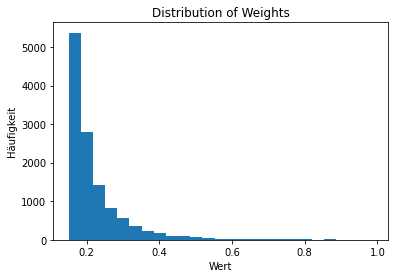

In [247]:
nn = len(graph['nodes'])
ne = len(graph['links'])
print( f"This graph has {nn} nodes and {ne} links.")

import matplotlib.pyplot as plt

weights=[]
for link in graph['links']:
    weights.append(link['weight'])
#print(sum(weights))

plt.hist(weights, bins=25)
plt.title("Distribution of Weights")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()

In [36]:
print(f'The graph has {len(graph["links"])} links.')

The graph has 37177 links.


In [248]:
import networkx as nx

graphforgephi = nx.Graph()
for node in tqdm.tqdm(graph['nodes']):
    graphforgephi.add_node(node['id'],name = node['name'],cALL = node['cALL'],cSPD = node['cSPD'],cFDP = node['cFDP'],cCDU = node['cCDU'],cLINKE = node['cLINKE'],cGRUENE = node['cGRUENE'], cAFD = node['cAFD'] );
    #if(node['name'] == 'Angela Merkel'):
    #    print(node['tops'])

print('nodes done')
for link in tqdm.tqdm(graph['links']):   
    graphforgephi.add_edge(link['source'],link['target'],weight = link['weight'])
print('links done')   
nx.write_gexf(graphforgephi, "../private/graphforgephi.gexf")
print('save done')

100%|██████████| 12176/12176 [00:00<00:00, 463336.23it/s]


nodes done
links done
save done


# Further Explorations

## Correlation Graph

In [ ]:
from sklearn.preprocessing import normalize
data = normalize(X01T,norm='l2',axis=1)
data.shape

In [ ]:
C = np.corrcoef(data.todense())

In [ ]:
C = np.nan_to_num(C, copy=True, nan=0.0, posinf=None, neginf=None)
C.shape

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
C_r = pca.fit(C).transform(C)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

In [ ]:
plt.figure(figsize=(10,10))
colors = ["navy", "turquoise", "darkorange"]
lw = 2
plt.scatter(C_r[:,0], C_r[:, 1],s=1, alpha=1)
plt.show()

In [ ]:


from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.3, min_df=2/len(corpus),norm='l2')
tf_idf_matrix  = vectorizer.fit_transform(corpus)

In [ ]:
tf_idf_matrix

## Second Tranform

In [ ]:
featurevec = vectorizer.get_feature_names()

In [ ]:
names = []
parties = []

for rede in reden:
    if rede['name'] not in names:
        names.append(rede['name'])
        parties.append(rede['party'])
        
parlamentarier = []

for count,name in tqdm.tqdm(enumerate(names)):
    hilf = {
        'id':count+1,
        'name': names[count],
        'party': parties[count]
    }
    
    text_lem = []
    for rede in reden:
        if rede['name'] == name:
            rel_lemmata = [ ele.lower() for ex,ele in enumerate(rede['text_lem']) if ele.lower() in featurevec  ]
            text_lem.extend(rel_lemmata)

    hilf.update({'text_lem': text_lem})

    parlamentarier.append(hilf)        
        

In [ ]:
#print(parlamentarier[0]['text_lem'])

In [ ]:


mentionedby = {}
for wort in featurevec:
    #print(wort)
    mentionedby.update({ wort : [] })
    

In [ ]:
if 'kollegin' in featurevec:
    print('ja')

In [ ]:
for parla in parlamentarier:
    for wort in parla['text_lem']: 
        mentionedby[wort].append(parla['name']) 

In [ ]:

    


corpus2=[  mentionedby[wort] for wort in mentionedby   ]

    


In [ ]:
#corpus2[0]

In [ ]:
vectorizer2 = TfidfVectorizer(vocabulary=featurevec,norm='l2')
tf_idf_matrix2  = vectorizer2.fit_transform(corpus2)

In [ ]:
tf_idf_matrix2

## Network

In [ ]:
pairwise_similarity = tf_idf_matrix2.T * tf_idf_matrix2
#pairwise_similarity = tf_idf_matrix * tf_idf_matrix.T
print(len(pairwise_similarity.toarray()))
similarity = pairwise_similarity.toarray()

In [ ]:
nodes = []
featurevec = vectorizer.get_feature_names()
for wx,word in enumerate(featurevec):
    node = {
        'id' : wx,
        'name' : word
    }
    nodes.append(node)
    

graph = {
    'directed': False,
    'graph': 'cooccurr_graph',
    'links': [],
    'nodes': nodes
}

In [ ]:
min_weight = 0.5
for ix,nodeI in tqdm.tqdm(enumerate(graph['nodes'])):
    for jx,nodeJ in enumerate(graph['nodes']):
        if nodeI['id'] < nodeJ['id']:
            source = nodeI['id']
            target = nodeJ['id']
            weight = similarity[ix,jx]
            if weight > min_weight:
                link_dict = {
                    'source':source,
                    'target':target,
                    'weight':weight       
                }
                graph['links'].append(link_dict)

In [ ]:
len(graph['links'])

In [ ]:
import networkx as nx

graphforgephi = nx.Graph()
for node in tqdm.tqdm(graph['nodes']):
    graphforgephi.add_node(node['id'],name = node['name']);
    #if(node['name'] == 'Angela Merkel'):
    #    print(node['tops'])

print('nodes done')
for link in tqdm.tqdm(graph['links']):   
    graphforgephi.add_edge(link['source'],link['target'],weight = link['weight'])
print('links done')   
nx.write_gexf(graphforgephi, "graphforgephi.gexf")
print('save done')